In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
from scipy.io import loadmat
from cmocean import cm
import warnings
#from cartopy import crs, feature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from salishsea_tools import viz_tools, places

#import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 11
warnings.simplefilter('ignore')

In [7]:
def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)


In [8]:
def plot_basemap(ax, w_map, color='Burlywood', lons=None, lats=None, loc=None, offset=[None, None], fill=True, zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.arange(*np.floor([w_map[0], w_map[1] + 1]))
    if lats is None:
        lats = np.arange(*np.floor([w_map[2], w_map[3] + 1]))
    
    # Labels
    if loc == 1:
        labels = [[0, 0, 1, 0], [0, 1, 0, 0]]
    elif loc == 2:
        labels = [[0, 0, 1, 0], [1, 0, 0, 0]]
    elif loc == 3:
        labels = [[0, 0, 0, 1], [1, 0, 0, 0]]
    elif loc == 4:
        labels = [[0, 0, 0, 1], [0, 1, 0, 0]]
    else:
        labels = [[0, 0, 0, 1], [1, 0, 0, 0]]
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    if fill:
        m.fillcontinents(color=color, zorder=zorder[0])
    m.drawmeridians(lons, labels=labels[0], color='k', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(lats, labels=labels[1], color='k', xoffset=offset[0], zorder=zorder[2])
    m.drawrivers(zorder=zorder[2])
    
    return m

In [9]:
def plot_map(ax, cst, bounds, grid, T):
    """Plot Strait of Georgia study area on Basemap object
    """
    
    # Plot Basemap
    w_map = [-127, -121, 46.5, 51.5]
    m = plot_basemap(ax, w_map, zorder=[0, 1, 7])
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    # Overlay model domain
    #C = ax.contourf(x, y, grid['Bathymetry'], range(0, 525, 25), cmap='Blues', extend='both', zorder=2)
    C = ax.contourf(x, y, T['vosaline'].isel(time_counter=0, deptht=0), range(15, 31), cmap=cm.haline, extend='both', zorder=2)
    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

    # Colorbar
    fig.subplots_adjust(bottom=0.15)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Salinity [g/kg]')
    cbar.set_label(label='Salinity [g/kg]', size=14)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), size=14)
    cbar.set_ticks(range(15, 35, 5))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)

    # Define Significant Landmarks and Locations
    annotations = {
        'Pacific\nOcean'     : {'text': [0.10, 0.250], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'British\nColumbia'  : {'text': [0.65, 0.850], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Washington\nState'  : {'text': [0.70, 0.030], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Strait of Georgia'  : {'text': [0.50, 0.575], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
        'Juan de Fuca Strait': {'text': [0.36, 0.400], 'font': 13, 'rotate': -21, 'color': 'r', 'marker': None, 'arrow': None},
        'Fraser River'       : {'text': [0.80, 0.530], 'font': 13, 'rotate':  15, 'color': 'r', 'marker': None, 'arrow': None},
        'Puget\nSound'       : {'text': [0.60, 0.120], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Vancouver'          : {'text': [0.68, 0.550], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.10, 49.25], 'arrow': None},
        'Victoria'           : {'text': [0.53, 0.380], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.37, 48.43], 'arrow': None},
        'Seattle'            : {'text': [0.81, 0.230], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-122.33, 47.61], 'arrow': None},
    }
    
    #ax.add_line(Rectangle([0.36, 0.575], 0.06, 0.06, transform=ax.transAxes, edgecolor='r', fill=False, linewidth=3, zorder=7))
    #ax.add_line(Rectangle([0.32, 0.680], 0.11, 0.09, transform=ax.transAxes, edgecolor='r', fill=False, linewidth=3, zorder=7))
    
    # Timestamp
    ax.text(0.02, 0.01, '30 March 2016 Daily Average', transform=ax.transAxes)
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=7)

In [10]:
def plot_domain(ax, grid):
    """Plot SalishSeaCast domain and bathymetry on Basemap object
    """
    
    # Plot Basemap
    w_map = [-126.3, -121, 46.8, 51.1]
    m = plot_basemap(ax, w_map, zorder=[0, 1, 5])

    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    # Overlay model domain
    C = ax.contourf(x, y, grid['Bathymetry'], range(0, 525, 25), cmap='Blues', zorder=2, extend='both')
    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

    # Colorbar
    fig.subplots_adjust(bottom=0.15)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Depth [m]')
    cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
    
    # Abbreviations
    JdFboundary = 'Juan de Fuca Strait\nOpen Boundary'
    JSboundary = 'Johnstone Strait\nOpen Boundary'
    
    # Define Significant Landmarks and Locations
    annotations = {
        JdFboundary    : {'text': [0.05, 0.30], 'font': 13, 'rotate':0, 'color': 'r', 'marker': None, 'arrow': [0.20, 0.35,  0.08,  0.040]},
        JSboundary     : {'text': [0.01, 0.43], 'font': 13, 'rotate':0, 'color': 'r', 'marker': None, 'arrow': [0.06, 0.47,  0.00,  0.360]},
        'Fraser\nRiver': {'text': [0.70, 0.70], 'font': 13, 'rotate':0, 'color': 'r', 'marker': None, 'arrow': [0.70, 0.69, -0.04, -0.035]},
    }
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=3)

In [11]:
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')


In [51]:
from salishsea_tools import nc_tools, viz_tools
from cmocean import cm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import numpy as np
import xarray as xr
import netCDF4 as nc

def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)
            
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')
    
def plot_map(fig, ax, grid, T, tplt, w_map = [-127, -121, 47, 51.2], idepth=0):
    """Plot Strait of Georgia study area on Basemap object
    """
    bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

    #rivers
    cst = loadmat('/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat')
    # Plot Basemap
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 7])
    
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    # Overlay model domain
    #C = ax.contourf(x, y, T['vosaline'].isel(time_counter=23, deptht=idepth), range(21, 34), cmap=cm.haline, extend='both', zorder=.2)
    
    #dat = T['Bathymetry'].isel(time_counter=0, deptht=idepth)
    dat = T['Bathymetry'][:,:]
    C = ax.contourf(x, y, dat, levels=np.arange(0, 600, 10), cmap=cm.dense, extend = 'both') # extend='both', zorder=.2)

    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

    # Colorbar
    fig.subplots_adjust(bottom=0.0)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='DIC [μmol/kg]')
    cbar.set_label(label='depth (m)', size=18)
    cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), size=18)
    cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
    
    #ax.scatter(-123.43,49.04,s=650,c='darkorange',marker='o')
    # Define Significant Landmarks and Locations
    annotations = {
#        'Pacific\nOcean'     : {'text': [0.10, 0.250], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#        'British\nColumbia'  : {'text': [0.65, 0.850], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#        'Washington\nState'  : {'text': [0.70, 0.030], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#        'Strait of Georgia'  : {'text': [0.50, 0.575], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
#        'Juan de Fuca Strait': {'text': [0.36, 0.400], 'font': 13, 'rotate': -21, 'color': 'r', 'marker': None, 'arrow': None},
#         'Fraser River'       : {'text': [0.80, 0.90], 'font': 13, 'rotate':  0, 'color': 'r', 'marker': None, 'arrow': None},
#         'Puget\nSound'       : {'text': [0.60, 0.120], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
#        '42'          : {'text': [0.68, 0.550], 'font': 14, 'rotate':   0, 'color': 'xkcd:red', 'marker': [-123.43, 49.04], 'markersize': 600, 'arrow': None},
#         '42'          : {'text': [0.68, 0.550], 'font': 14, 'rotate':   0, 'color': 'xkcd:red', 'marker': [-122.43, 49.04], 'markersize': 600, 'arrow': None},
#         '42'          : {'text': [0.68, 0.550], 'font': 14, 'rotate':   0, 'color': 'azure', 'marker': [-123.43, 49.04], 'markersize': 600, 'arrow': None},
        
#         'Victoria'           : {'text': [0.25, 0.39], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.37, 48.43], 'arrow': None},
#        'Seattle'            : {'text': [0.81, 0.230], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-122.33, 47.61], 'arrow': None},
    }
    
    
    # Timestamp
    ax.text(0.02, 0.01, ' ', transform=ax.transAxes, fontsize = 20)
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=7)
    
    # Plot Thalweg
    plot_thalweg(ax, x, y)    
    
    
#


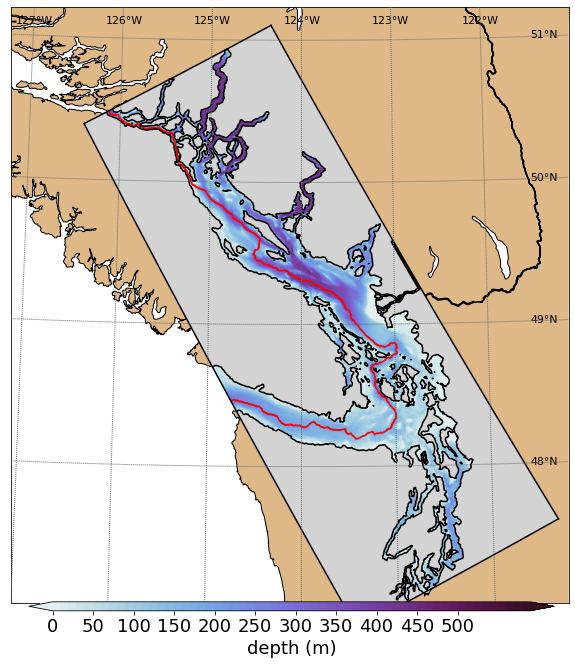

In [52]:
grid_NEMO = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
T_NEMO = xr.open_dataset('/data/tjarniko/results/BASERUN_EXP/PILA3_rerun/LA3/ncs/SKOG_1d_20151127_20151231_ptrc_T_20151231-20151231.nc')

# Plot Model Domain
fig, ax = plt.subplots(1, 1, figsize=(10, 12.5))
plot_map(fig, ax, grid_NEMO, bathy, tplt, w_map = [-127, -121, 47, 51.2], idepth=0)


# subplot examples:
https://www.machinelearningplus.com/plots/matplotlib-tutorial-complete-guide-python-plot-examples/

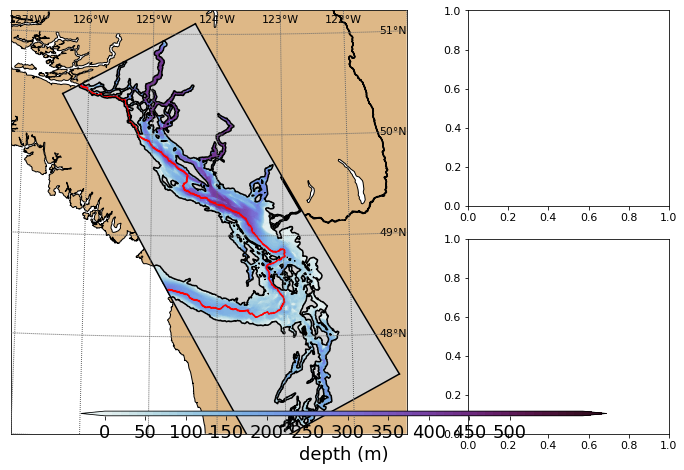

In [71]:
fig = plt.figure(figsize=(10, 6.5))
ax1 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2) # topleft
ax3 = plt.subplot2grid((2,3), (0,2), rowspan=1) 
ax3 = plt.subplot2grid((2,3), (1,2), rowspan=1)# right
#ax4 = plt.subplot2grid((2,3), (2,0))                       # bottom left
#ax5 = plt.subplot2grid((2,3), (2,1))   
plot_map(fig, ax1, grid_NEMO, bathy, tplt, w_map = [-127, -121, 47, 51.2], idepth=0)
# bottom right
fig.tight_layout()